A colleague came to me with a question. She had some Herschel data in a FITS image with world coordinate system information (WCS) as well as some derived data in pixel coordinates based on that image. She wanted to create a new FITS image with WCS information to allow her to match the two images. It turns out the simplest way to explain how to do that was basically to write a blog post, so here we are.

To begin, use the usual incantations to bring in matplotlib and NumPy:

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.print_figure_kwargs = {'facecolor': (1.0, 1.0, 1.0, 0.0)}
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
# correct image orientation and improve appearance:
matplotlib.rcParams.update({
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'font.family': 'serif',
})

# not great practice for real code, but we can safely ignore
# warnings in this example:
import warnings
warnings.simplefilter('ignore')

## Load a FITS image with world coordinate system info

To work with, we're using an image from the [Herschel M33 Extended Survey (HerM33es)](https://irsa.ipac.caltech.edu/data/Herschel/HerM33es/) (PI: Kramer) taken with the SPIRE instrument at a wavelength of 350 µm. We're going to retrieve the Herschel image from the NASA/IPAC Infrared Science Archive with Python, but you could just as easily download it [here](https://irsa.ipac.caltech.edu/data/Herschel/HerM33es/images/spire_350_v6.fits) and drop it in this directory.

In [2]:
from urllib.request import urlretrieve
from os.path import exists
url = 'https://irsa.ipac.caltech.edu/data/Herschel/HerM33es/images/spire_350_v6.fits'
dst = 'spire_350_v6.fits'
if not exists(dst):
    urlretrieve(url, dst)
dst

'spire_350_v6.fits'

Let's see what we got:

Filename: spire_350_v6.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (765, 791)   float32   


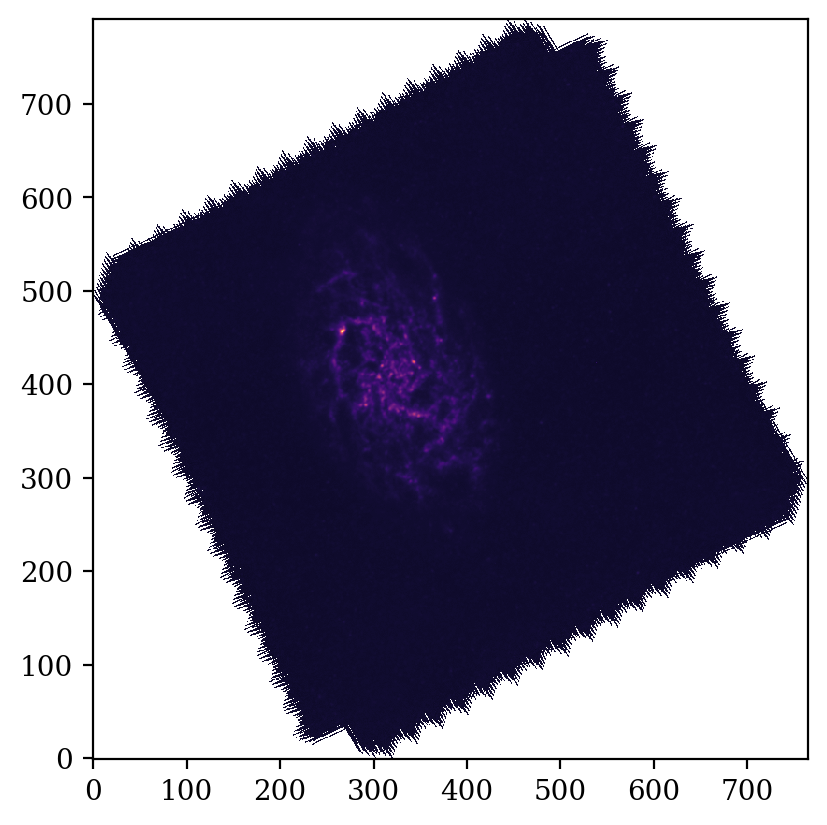

In [3]:
from astropy.io import fits
hdul = fits.open(dst)
image = hdul[0].data
plt.imshow(image)
hdul.info()

Functionality to convert between sky coordinates (e.g. RA and Dec) and pixels is in `astropy.wcs`, mostly accessed through instances of the `WCS` class.

In [4]:
from astropy.wcs import WCS

The `WCS` class can be initialized with an existing set of WCS transformations drawn from a FITS header, so we pass in the header of our Herschel image:

In [5]:
wcs = WCS(header=hdul[0].header)

To plot on axes labeled with the celestial coordinates for our image, we pass `projection=wcs` when creating our axes.

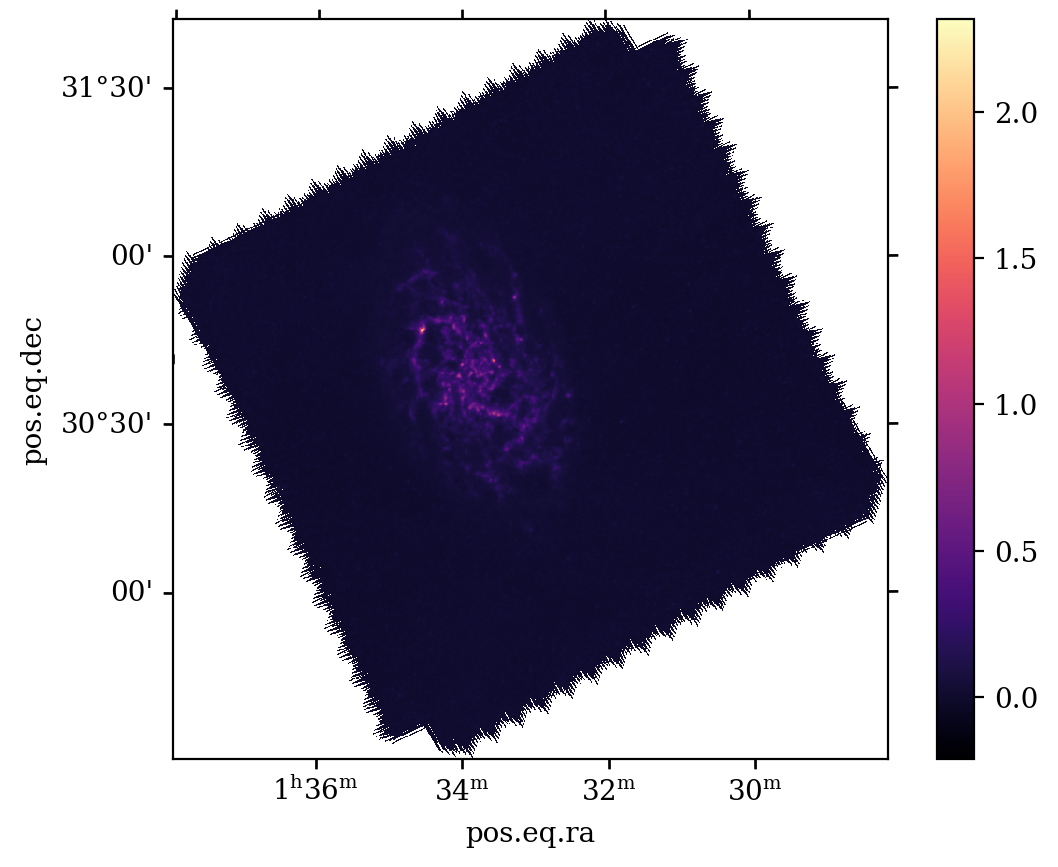

In [6]:
ax = plt.subplot(projection=wcs)
im = ax.imshow(image)
plt.colorbar(im)

## Converting world coordinates to pixels

Now let's do some manipulations in pixel space. First, suppose we're only interested in the regions from 23º to 24º in (decimal) RA and 30º to 31º in Dec. [WCSAxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) (the underlying translation layer from WCS to matplotlib axes coordinates) doesn't let us set limits in RA and Dec (yet?) so we convert the coordinates of our lower left and upper right corner.

The way to do this is the `all_world2pix(ra, dec, origin)` method, which takes arrays of RAs and Decs (or whatever world coordinates are used for this file) and an origin (Python starts counting array indices at 0) to produce pixel coordinates following the WCS transformations.

In [7]:
dec_ll, ra_ll = 30, 24
dec_ur, ra_ur = 31, 23

(xmin, xmax), (ymin, ymax) = wcs.all_world2pix([ra_ll, ra_ur], [dec_ll, dec_ur], 0)
(xmin, xmax), (ymin, ymax)

((153.08980468200764, 463.3540706746549),
 (175.87070636604258, 535.8266619757949))

Now we pass `(xmin, xmax)` and `(ymin, ymax)` to set the axis limits in pixels and crop our image to the region of interest:

[(153.08980468200764, 463.3540706746549),
 (175.87070636604258, 535.8266619757949)]

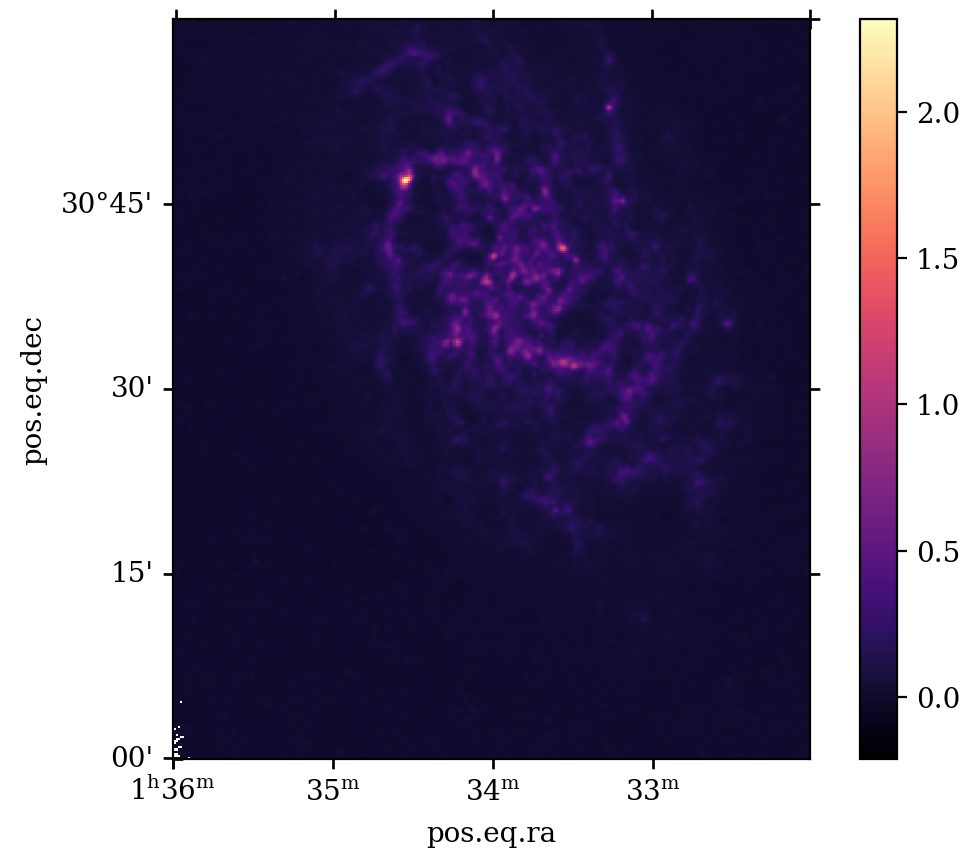

In [8]:
ax = plt.subplot(projection=wcs)
im = ax.imshow(image)
plt.colorbar(im)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

Say we wanted to cut the corresponding part of the underlying array. See how we have non-integer values for our axis limits? That won't work for array slicing. Since you usually want to err on the side of keeping more data, round the minima down and maxima up:

In [9]:
xmin_int, xmax_int = int(np.floor(xmin)), int(np.ceil(xmax))
ymin_int, ymax_int = int(np.floor(ymin)), int(np.ceil(ymax))
(xmin_int, xmax_int), (ymin_int, ymax_int)

((153, 464), (175, 536))

Recall that NumPy interprets array indices with x coordinate last (so, `(y, x)` for our 2D image). Cut out the corresponding region with slice syntax:

In [10]:
subregion = image[ymin_int:ymax_int,xmin_int:xmax_int]

Make sure it looks right:

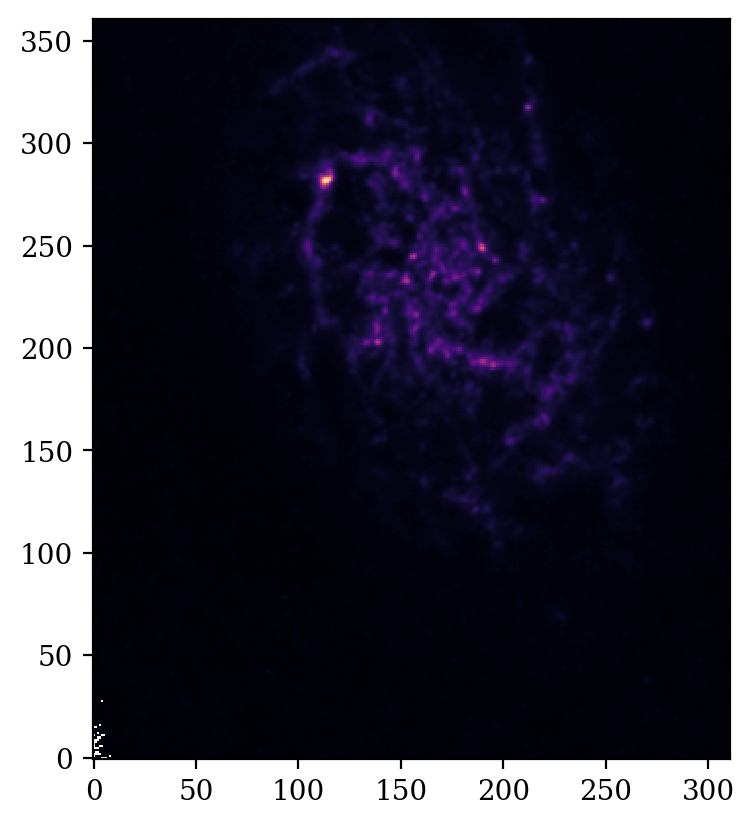

In [11]:
_ = plt.imshow(subregion)

Now, suppose we did something interesting in pixel coordinates with this cutout. I'm just going to make a binary (True/False) mask for areas of high flux.

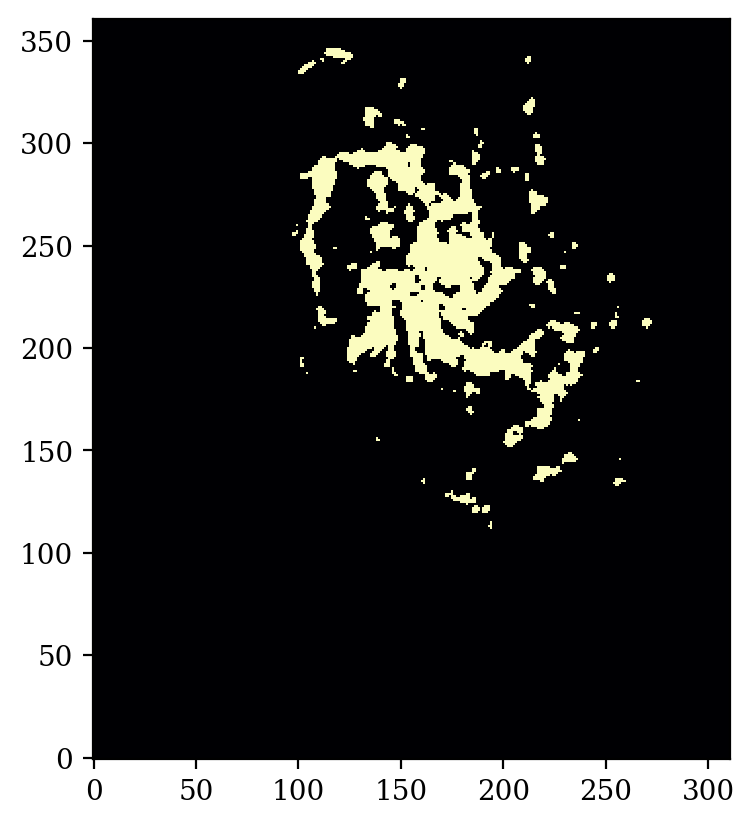

In [12]:
mask = (subregion > 0.2).astype(int)
_ = plt.imshow(mask)

Fancy. Now, this is where my colleague got stuck. She had this image in pixels on the same grid as a Herschel image, but covering only part of the region. She wanted to assign world coordinate system information to this pixel grid and write it back out to a FITS file for use in another tool.

## Creating an updated world coordinate system for our cutout

World coordinate transformations are pretty tricky to get right; that's why we have computers do them for us. Assigning them to astronomical images from telescope pointing centers and instrument distortion maps is a whole blog post or four in itself.

Fortunately, since we have WCS information from our Herschel data, we can borrow their transformations. Let's peek inside the `wcs` object:

In [13]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 23.4775063136  30.6346982677  
CRPIX : 317.0  405.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00277777777778  0.00277777777778  
NAXIS : 765  791

These are just the values from the FITS header. For all the gory details, see the authoritative FITS standards for WCS: [Representations of World Coordinates in FITS](http://adsabs.harvard.edu/abs/2002A%26A...395.1061G) (Paper I), Greisen & Calabretta (2002) and [Representations of celestial coordinates in FITS](http://adsabs.harvard.edu/abs/2002A%26A...395.1077C) (Paper II), Calabretta & Greisen (2002). (Or follow the links on the [FITS website](https://fits.gsfc.nasa.gov/fits_wcs.html) maintained at NASA Goddard Space Flight Center.)

For this simplified example, I'll spare you the pain of reading those papers. The `RA---TAN` and `DEC---TAN` means we're in the tangent plane approximation. As you may remember, you can define a line tangent to a curve at some point and then talk about small displacements about that point along the curve as if they were linear. Since we talk about astronomical sources in terms of their angles on a celestial sphere, we have a tangent _plane_ instead of a line, but the principle is the same. The `CRVAL` and `CRPIX` values define the tangent point in both coordinate systems.

The `CDELT` values explain how far you move in the corresponding _celestial_ coordinate when you move 1 pixel in X or Y. (Note that we're back in `(x, y)` order when talking about RA and Dec with the WCS info.)

So, you might think that transforming the `CRPIX` values (317, 405) to world coordinates would give you `CRVAL`, but...

In [14]:
wcs.all_pix2world(317, 405, 0)

[array(23.47427787), array(30.63747601)]

What's going on? Well, that `0` we're sticking at the end? That's the origin. Python starts counting array indices at zero, but not every language agrees. The FITS standard, for example, defines `1.0` as the leading edge of the first pixel. (The center of the pixel is then 1.5, rather than 0.5) It's really an arbitrary choice, so we're asked which convention to use whenever we call `all_pix2world`. Let's check with an origin of `1`:

In [15]:
wcs.all_pix2world(317, 405, 1)

[array(23.47750631), array(30.63469827)]

**There's** the `CRVAL` we were looking for.

We need to make a new WCS object for the subregion image. Since we have taken a slice out of the original image, our CRPIX location has changed. We've taken `(xmin_int, ymin_int) -> (0, 0)` by slicing, so our new `CRPIX` coordinates are `CRPIX1 - xmin_int` and `CRPIX2 - ymin_int`. Additionally, the NAXIS values have to be changed to reflect the new shape of the array.

It turns out that Astropy WCS object supports a `slice` method to do this for us. When we wrote `subregion = image[ymin_int:ymax_int,xmin_int:xmax_int]` above, we were making a **slice** of the original array `image`. The extent of that slice is the `ymin_int:ymax_int,xmin_int:xmax_int` specified between the square brackets.

This is just special syntax for making a `slice` object, which can be constructed with the built-in `slice()` function. In that form, our slice above would look like:

In [16]:
slices = (slice(ymin_int, ymax_int), slice(xmin_int, xmax_int))

We can use those slice objects just like an explicit `from:to` slice specifier:

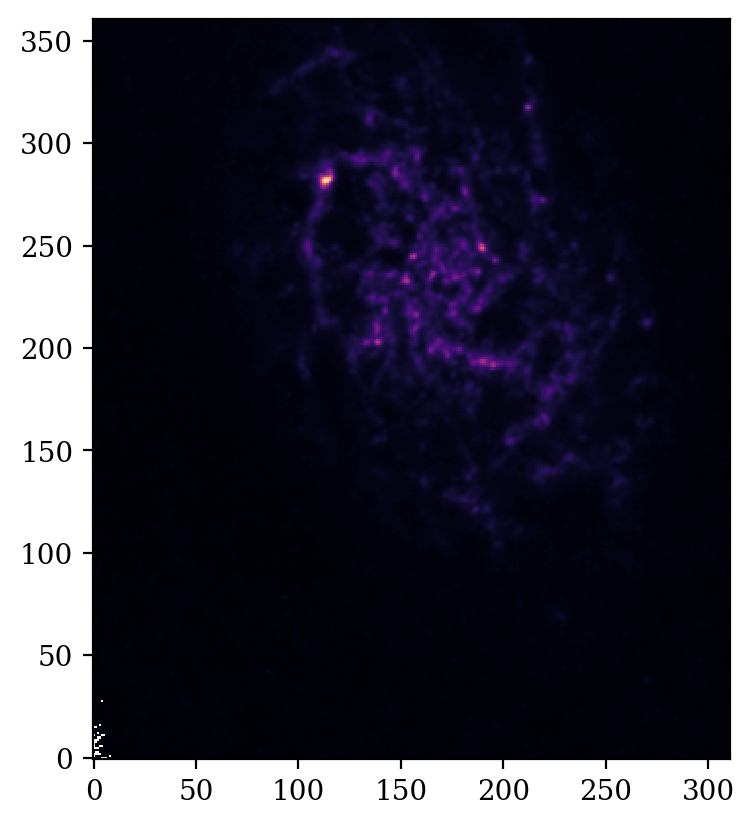

In [17]:
sliced = image[slices]
_ = plt.imshow(sliced)

Now, why might you want to have slices as objects rather than written out in your code? Well, one reason is that you can pass objects to functions and store references to them in case you need to use the same slice in more than one place. We can use our `slices` tuple to slice both the data array and the WCS using the Astropy WCS `slice()` method.

The `wcs.slice()` method takes a tuple of these slice objects **in Python axis ordering**, just as you'd use to slice the underlying array. Let's see what we get for our sliced WCS:

In [18]:
subregion = image[slices]
new_wcs = wcs.slice(slices)
new_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 23.4775063136  30.6346982677  
CRPIX : 164.0  230.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00277777777778  0.00277777777778  
NAXIS : 311  361

As we expected, the CRPIX values have been modified by subtracting the minimum X and Y of our cutout in the original pixel coordinates.

If we did everything right, our cropped plot of the original image should have the same limits as a plot of the new mask with the new WCS.

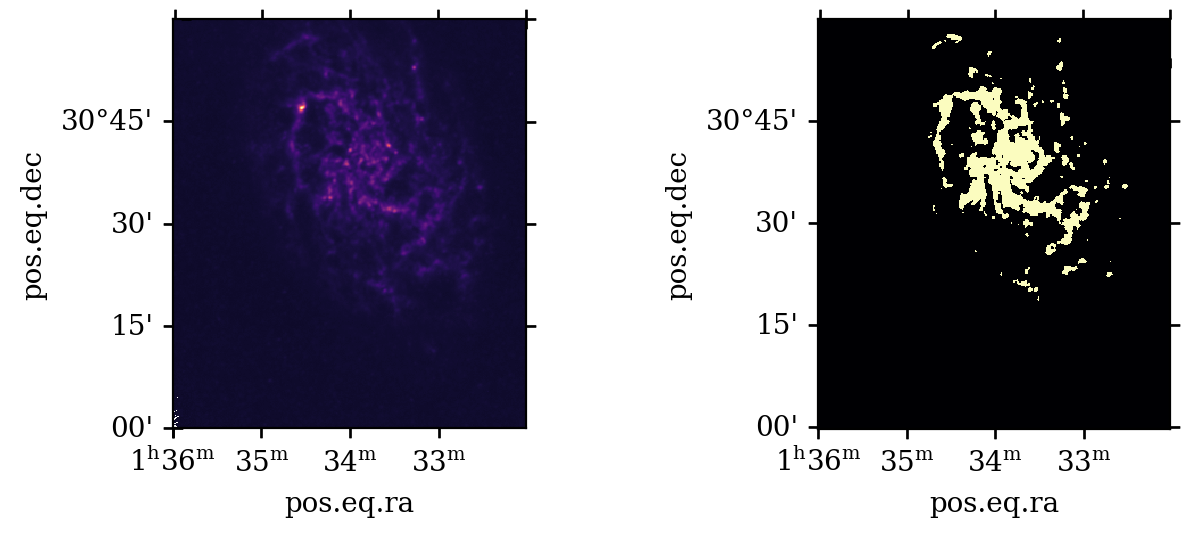

In [19]:
ax1 = plt.subplot(1, 2, 1, projection=wcs)
ax1.imshow(image)
ax1.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax2 = plt.subplot(1, 2, 2, projection=new_wcs)
ax2.imshow(mask)
plt.tight_layout(w_pad=5)

## Writing the new data and WCS to a FITS file

Finally, we wanted to write this mask out to a file with embedded WCS information. The Astropy WCS object has a method `to_fits` that converts the internal WCS representation into FITS format using Astropy FITS support. The return value is a `HDUList`, like you'd get from opening a file, but the `data` for the first HDU is absent:

In [20]:
output_hdul = new_wcs.to_fits()
output_hdul[0].data is None

True

To make this a useful file, it needs to have image data. We can just assign our 2D mask array to the data attribute as follows:

In [21]:
output_hdul[0].data = mask

And write it out:

In [22]:
output_hdul.writeto("mask_example.fits", overwrite=True)

To make sure it survived the round trip, let's load that file up afresh and ensure we can reproduce the comparison plot above:

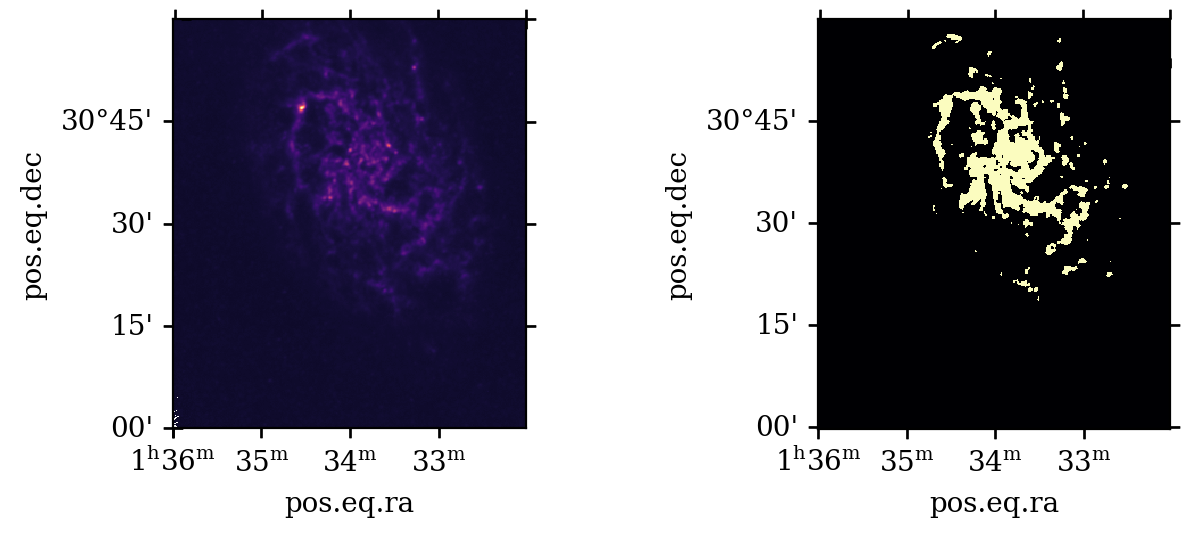

In [23]:
from_output_hdul = fits.open('./mask_example.fits')
from_output_mask = from_output_hdul[0].data
from_output_wcs = WCS(header=from_output_hdul[0].header)

ax1 = plt.subplot(1, 2, 1, projection=wcs)
ax1.imshow(image)
ax1.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax2 = plt.subplot(1, 2, 2, projection=from_output_wcs)
ax2.imshow(from_output_mask)
plt.tight_layout(w_pad=5)

Neat.

### Further reading

  - [Making plots with world coordinates (WCSAxes)](http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) in the Astropy documentation
  - [FITS World Coordinate System references](https://fits.gsfc.nasa.gov/fits_wcs.html)
  - [World Coordinate System](http://docs.astropy.org/en/stable/wcs/index.html) in the Astropy documentation
  - [FITS File Handling](http://docs.astropy.org/en/stable/io/fits/index.html) in the Astropy documentation, in particular [Creating a new FITS file](http://docs.astropy.org/en/stable/io/fits/index.html#creating-a-new-fits-file)

### Acknowledgments

Thanks to Samantha Scibelli ([@samscibelli](https://twitter.com/samscibelli)) for reading this before publication and spotting my mistakes!